In [161]:
from pathlib import Path

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
import seaborn as sns

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

JSON_DIR = Path("../results/raw/cg/sample/")

df = pd.concat(map(pd.read_json, JSON_DIR.iterdir()), ignore_index=True).rename(
    columns={"dataset_and_task": "dataset", "rogi": "ROGI", "rmse": "RMSE", "cg_sds": "sds"}
)

df[["thresholds", "sds", "n_clusters"]] = df[["thresholds", "sds", "n_clusters"]].applymap(np.array)

df["cr"] = 1 - (df["n_clusters"] / df["n_valid"])
df["cr_log"] = 1 - (df["n_clusters"].map(np.log) / df["n_valid"].apply(np.log))

df.head()

,features,dataset,ROGI,n_valid,thresholds,sds,n_clusters,cr,cr_log
0,vae,CLEARANCE_HEPATOCYTE_AZ,0.577498,1213,"[0.0, 0.019150548700000002, 0.0291771006000000...","[0.677915252, 0.6778845417, 0.6666693656, 0.60...","[1213, 1212, 1116, 808, 556, 380, 278, 213, 17...","[0.0, 0.0008244023083264773, 0.079967023907666...","[0.0, 0.00011614695326234159, 0.01173743194078..."
1,vae,CLEARANCE_HEPATOCYTE_AZ,0.571063,1213,"[0.0, 0.0207421666, 0.0307702285, 0.0407842622...","[0.677915252, 0.6778844101, 0.6597215955, 0.59...","[1213, 1212, 1081, 783, 525, 369, 272, 212, 16...","[0.0, 0.0008244023083264773, 0.108821104699093...","[0.0, 0.00011614695326234159, 0.01622482665209..."
2,vae,CLEARANCE_HEPATOCYTE_AZ,0.567980,1213,"[0.0, 0.0200769627, 0.0300892346, 0.0400939603...","[0.677915252, 0.6778845417, 0.6633799442, 0.60...","[1213, 1212, 1098, 790, 531, 369, 270, 213, 16...","[0.0, 0.0008244023083264773, 0.094806265457543...","[0.0, 0.00011614695326234159, 0.01402737138470..."
3,vae,CLEARANCE_HEPATOCYTE_AZ,0.568768,1213,"[0.0, 0.0199039871, 0.029925520100000002, 0.03...","[0.677915252, 0.6778845417, 0.6605959281, 0.59...","[1213, 1212, 1102, 792, 544, 373, 272, 212, 16...","[0.0, 0.0008244023083264773, 0.091508656224237...","[0.0, 0.00011614695326234159, 0.01351526837368..."
4,vae,CLEARANCE_HEPATOCYTE_AZ,0.572368,1213,"[0.0, 0.020181587100000002, 0.0301855397, 0.04...","[0.677915252, 0.6779152519, 0.6583908003000001...","[1213, 1212, 1097, 786, 532, 366, 282, 212, 17...","[0.0, 0.0008244023083264773, 0.095630667765869...","[0.0, 0.00011614695326234159, 0.01415568863536..."


In [162]:
def dispersion_plot(ax: plt.Axes, x: np.ndarray, sds: np.ndarray):
    BUFFER = 0.03
        
    y = sds[0] - sds
    ax.plot(x, y, '-')
    ax.fill_between(x, 0, y, alpha=0.3)

    rogi = sds[0] - trapezoid(sds, x)
    s = f"ROGI = {rogi:0.3f}"
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='none')
    ax.text(
        0 + BUFFER, 1 - BUFFER, s,
        ha="left", va="top", fontsize=10, transform=ax.transAxes, bbox=bbox
    )
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0)
    ax.yaxis.set_tick_params(which="both", direction="in", pad=6)
    ax.grid(False)

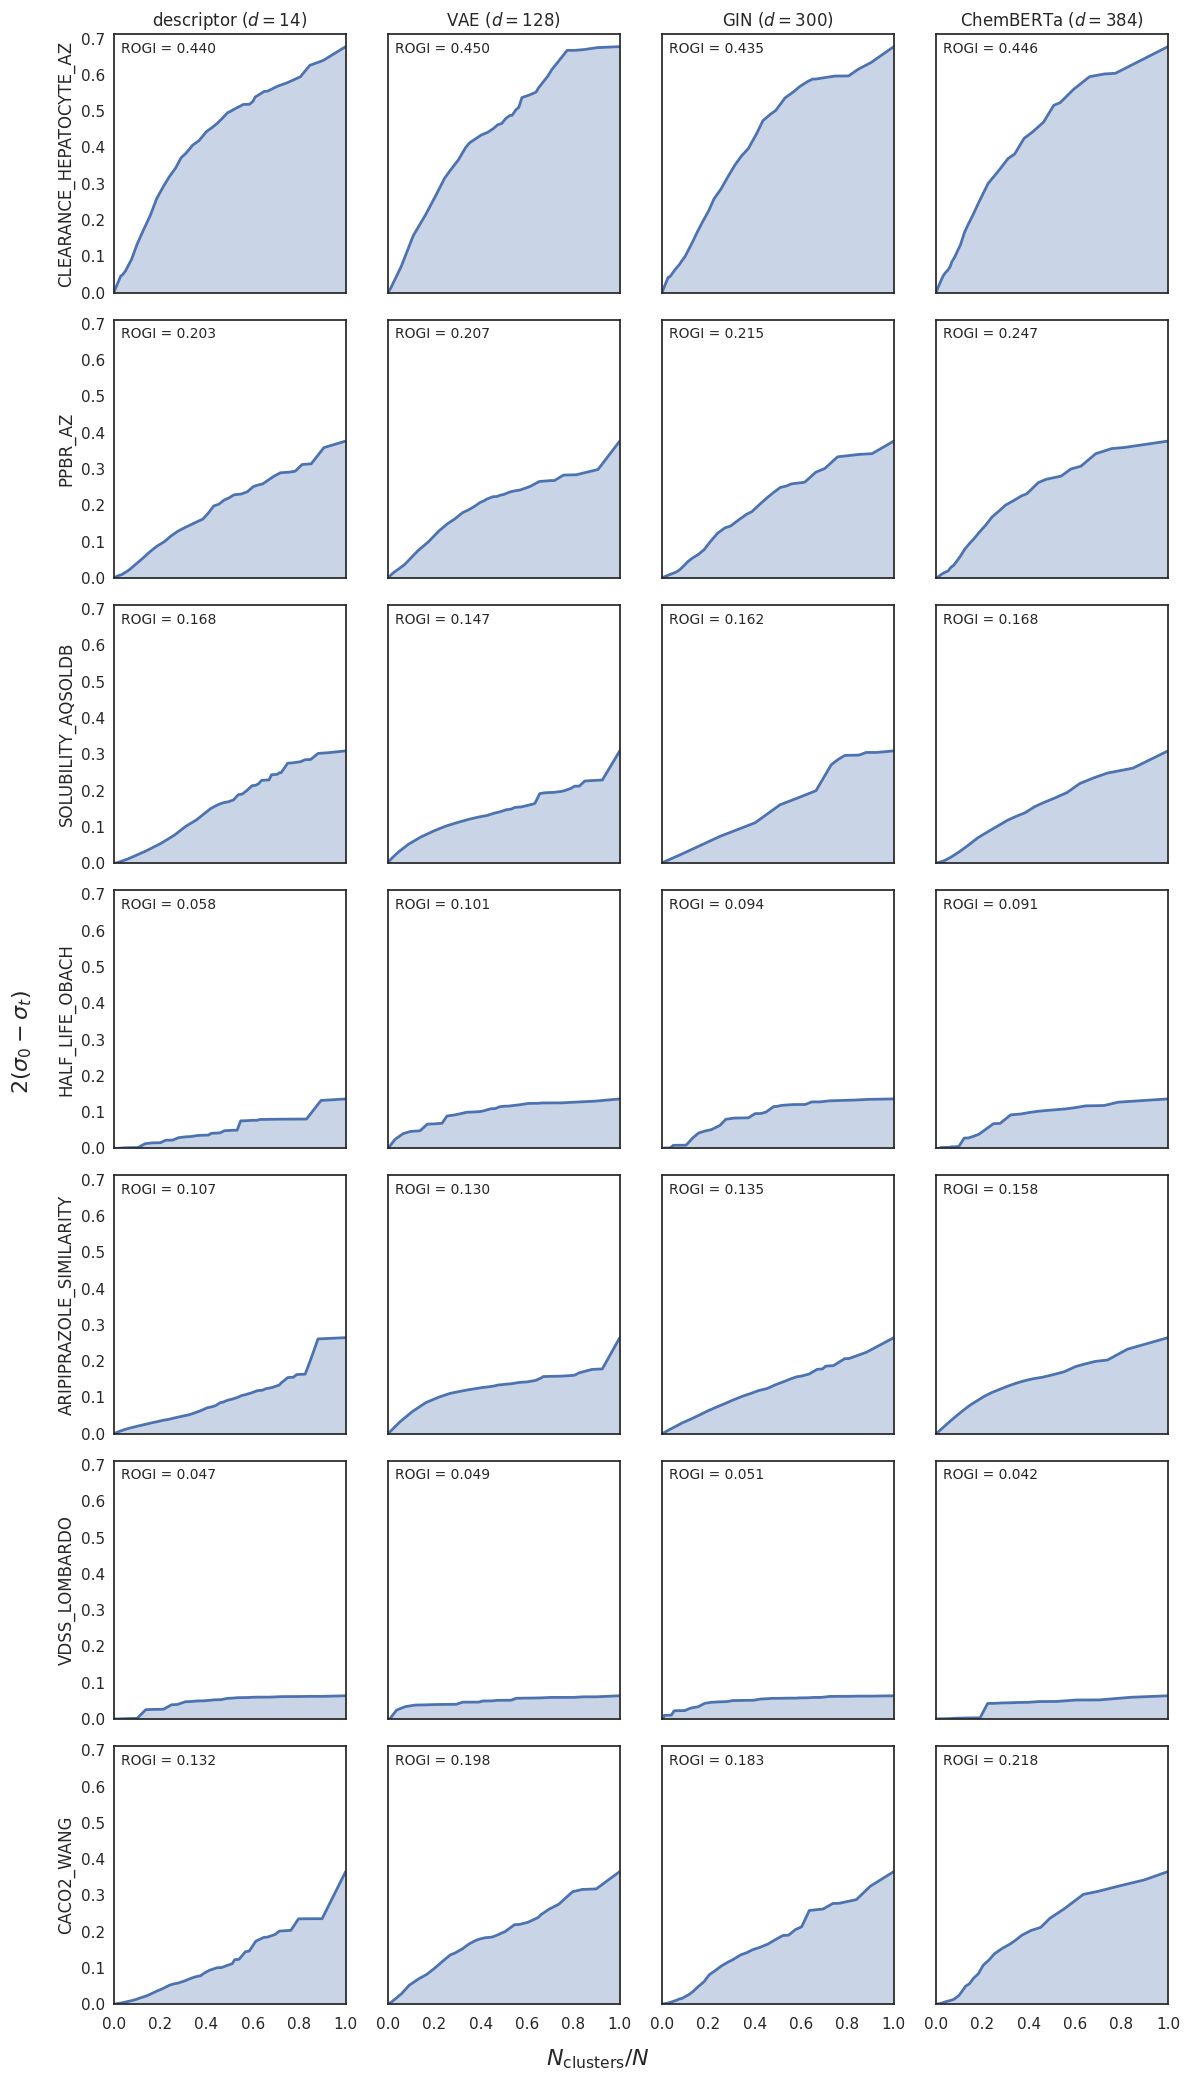

In [164]:
# data = df[df["dataset"].isin(["CACO2_WANG", "ARIPIPRAZOLE_SIMILARITY"])]
data = df

DATASETS = data["dataset"].unique()
FEATURES = ["descriptor", "VAE", "GIN", "ChemBERTa"]
X_KEY = "cr_log"

nrows = len(DATASETS)
ncols = len(FEATURES)
fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), sharex=True, sharey=True)

dims = [14, 128, 300, 384, 2048]
f2dim = dict(zip(FEATURES, dims))

for i, dset in enumerate(DATASETS):
    for j, feature in enumerate(FEATURES):
        s = data.query(f"dataset == '{dset}' and features == '{feature.lower()}'")
        dispersion_plot(axs[i, j], s[X_KEY].values[0], s.sds.values[0])

        if i == 0:
            axs[i, j].set_title(rf"{feature} ($d={f2dim[feature]}$)")
        if j == 0:
            axs[i, j].set_ylabel(dset)

fig.subplots_adjust(wspace=1)
fig.supxlabel(r"$N_{\mathrm{clusters}} / N$", fontsize=16)
fig.supylabel(r"$2(\sigma_0 - \sigma_t)$", x=0.01, fontsize=16)

fig.tight_layout()

In [160]:
fig.savefig("../results/figures/thresh-vs-sds_ratio.pdf", bbox_inches="tight")